# 时间序列预测

In [67]:
import csv, sys, os, math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

workdir = 'D:\RNAseq\Experiment\PatternRP\work'
data = pd.read_csv(r"C:\Users\14816\Desktop\project\Covid_TimeSeriesAnalysis\clean_data.csv", index_col=[0], parse_dates=[0])

In [68]:
data

,Confirmed,Deaths,Recovered
ObservationDate,,,
2020-01-26,2.0,0.0,0.0
2020-01-27,2.0,0.0,0.0
2020-01-28,2.0,0.0,0.0
2020-01-29,2.0,0.0,0.0
2020-01-30,2.0,0.0,0.0
...,...,...,...
2021-05-25,3779998.0,62986.0,0.0
2021-05-26,3781120.0,63017.0,0.0
2021-05-27,3786459.0,63168.0,0.0


# 季节性分析

<Figure size 3000x1500 with 0 Axes>

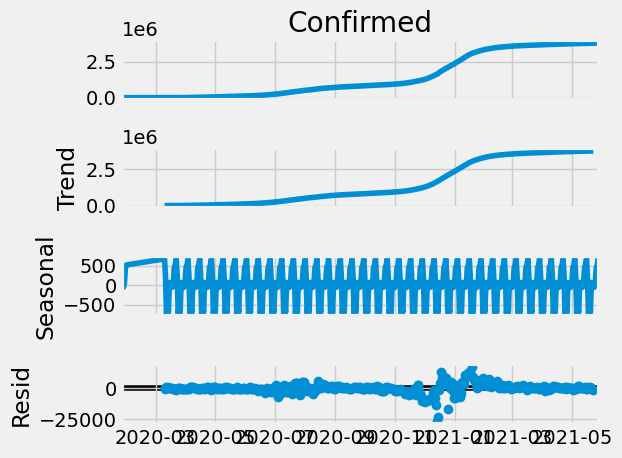

In [133]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

series = data['Confirmed']
result = seasonal_decompose(series, model='additive', period=12)

# 绘制结果
plt.figure(figsize=(30, 15))
result.plot()
plt.show()

# Train/Test Split
### Cut off the data after 2021-05-01 to use as our validation set.

In [69]:
split_date = '2021-05-01'
train = data.loc[data.index < split_date].copy()
test = data.loc[data.index >= split_date].copy()

In [70]:
train

,Confirmed,Deaths,Recovered
ObservationDate,,,
2020-01-26,2.0,0.0,0.0
2020-01-27,2.0,0.0,0.0
2020-01-28,2.0,0.0,0.0
2020-01-29,2.0,0.0,0.0
2020-01-30,2.0,0.0,0.0
...,...,...,...
2021-04-26,3734562.0,61500.0,0.0
2021-04-27,3736745.0,61526.0,0.0
2021-04-28,3738327.0,61587.0,0.0


In [71]:
test

,Confirmed,Deaths,Recovered
ObservationDate,,,
2021-05-01,3743681.0,61866.0,0.0
2021-05-02,3744937.0,61939.0,0.0
2021-05-03,3747337.0,61967.0,0.0
2021-05-04,3749580.0,62029.0,0.0
2021-05-05,3750644.0,62070.0,0.0
2021-05-06,3753173.0,62154.0,0.0
2021-05-07,3755869.0,62220.0,0.0
2021-05-08,3757115.0,62280.0,0.0
2021-05-09,3758137.0,62314.0,0.0


In [72]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    #df['hour'] = df['date'].dt.hour
    #df['dayofweek'] = df['date'].dt.dayofweek
    #df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    #df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    #df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['year','month','dayofmonth']]
    if label:
        y = df[label]
        return X, y
    return X

In [73]:
X_train, y_train = create_features(train, label='Confirmed')
X_test, y_test = create_features(test, label='Confirmed')

In [74]:
X_test.shape

(29, 3)

# Create Model
## XGBoost

In [57]:
xgbreg = xgb.XGBRegressor(n_estimators = 100, early_stopping_rounds=10)
xgbreg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        #early_stopping_rounds = 50,
       verbose = True)

[0]	validation_0-rmse:1382956.10435	validation_1-rmse:2696436.94517
[1]	validation_0-rmse:978735.94234	validation_1-rmse:1943677.19374
[2]	validation_0-rmse:694949.12122	validation_1-rmse:1436824.53045
[3]	validation_0-rmse:493962.50434	validation_1-rmse:1057766.41635
[4]	validation_0-rmse:351896.88617	validation_1-rmse:774869.13384
[5]	validation_0-rmse:251435.57608	validation_1-rmse:575488.69407
[6]	validation_0-rmse:180177.85857	validation_1-rmse:434977.85097
[7]	validation_0-rmse:129533.44905	validation_1-rmse:325293.77099
[8]	validation_0-rmse:93675.08698	validation_1-rmse:250699.99425
[9]	validation_0-rmse:68335.81986	validation_1-rmse:194580.60653
[10]	validation_0-rmse:50429.08869	validation_1-rmse:158500.01329
[11]	validation_0-rmse:37740.09927	validation_1-rmse:130260.40284
[12]	validation_0-rmse:28760.01969	validation_1-rmse:110263.19352
[13]	validation_0-rmse:22253.26460	validation_1-rmse:97011.76913
[14]	validation_0-rmse:17837.43741	validation_1-rmse:86539.49669
[15]	vali

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

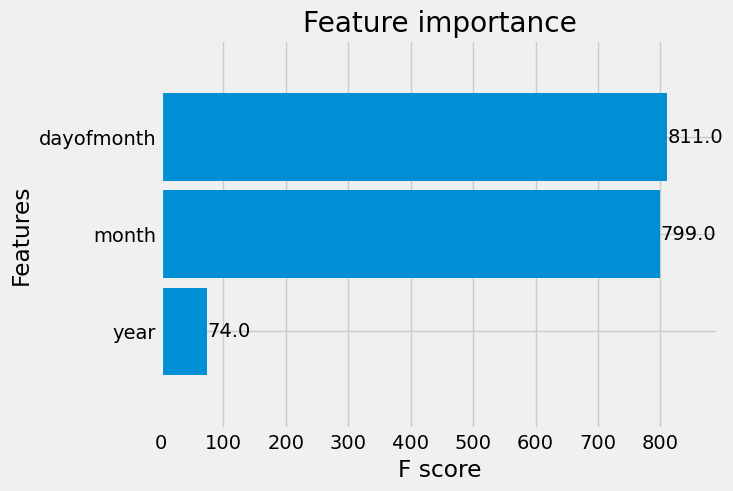

In [58]:
plot_importance(xgbreg, height=0.9)

In [36]:
X_test

,year,month,dayofmonth
ObservationDate,,,
2021-05-01,2021,5,1
2021-05-02,2021,5,2
2021-05-03,2021,5,3
2021-05-04,2021,5,4
2021-05-05,2021,5,5
2021-05-06,2021,5,6
2021-05-07,2021,5,7
2021-05-08,2021,5,8
2021-05-09,2021,5,9


In [59]:
test['Confirmed_Prediction'] = xgbreg.predict(X_test)

In [38]:
test

,Confirmed,Deaths,Recovered,date,month,year,dayofmonth,Confirmed_Prediction
ObservationDate,,,,,,,,
2021-05-01,3743681.0,61866.0,0.0,2021-05-01,5,2021,1,3671717.50
2021-05-02,3744937.0,61939.0,0.0,2021-05-02,5,2021,2,3674942.50
2021-05-03,3747337.0,61967.0,0.0,2021-05-03,5,2021,3,3676791.25
2021-05-04,3749580.0,62029.0,0.0,2021-05-04,5,2021,4,3677839.25
2021-05-05,3750644.0,62070.0,0.0,2021-05-05,5,2021,5,3683226.50
2021-05-06,3753173.0,62154.0,0.0,2021-05-06,5,2021,6,3684066.75
2021-05-07,3755869.0,62220.0,0.0,2021-05-07,5,2021,7,3684730.25
2021-05-08,3757115.0,62280.0,0.0,2021-05-08,5,2021,8,3684205.25
2021-05-09,3758137.0,62314.0,0.0,2021-05-09,5,2021,9,3696451.75


## Error Metrics On Test Set
### Our RMSE error is 3446373669.1810346
### Our MAE error is 58090.724137931036
### Our MAPE error is 1.543%

In [60]:
mean_squared_error(y_true=test['Confirmed'],
                   y_pred=test['Confirmed_Prediction'])

3446373669.1810346

In [61]:
mean_absolute_error(y_true=test['Confirmed'],
                   y_pred=test['Confirmed_Prediction'])

58090.724137931036

In [62]:
# MAPE看预测的偏差程度 这里要引用一下mean absolute percent error的文献~
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [63]:
mean_absolute_percentage_error(y_true=test['Confirmed'],
                   y_pred=test['Confirmed_Prediction'])

1.5429154984261344

## Worst and Best Predicted Days

In [64]:
test['error'] = test['Confirmed'] - test['Confirmed_Prediction']
test['abs_error'] = test['error'].apply(np.abs)
error_by_day = test.groupby(['year','month','dayofmonth']) \
    .mean(numeric_only=True)[['Confirmed','Confirmed_Prediction','error','abs_error']]
error_by_day.sort_values('error', ascending=True).head(10)

Confirmed  Confirmed_Prediction     error  abs_error
year month dayofmonth                                                      
2021 5     24          3778555.0            3730975.75  47579.25   47579.25
           25          3779998.0            3730975.75  49022.25   49022.25
           18          3771240.0            3721523.25  49716.75   49716.75
           19          3772702.0            3722849.00  49853.00   49853.00
           26          3781120.0            3731221.50  49898.50   49898.50
           29          3788713.0            3738017.00  50696.00   50696.00
           17          3769827.0            3718670.25  51156.75   51156.75
           21          3775619.0            3724441.50  51177.50   51177.50
           23          3777077.0            3725876.00  51201.00   51201.00
           20          3774494.0            3722723.25  51770.75   51770.75

## Prophet

In [42]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [43]:
# rename
train.reset_index() \
    .rename(columns={'ObservationDate':'ds',
                     'Confirmed':'y'}).head()

,ds,y,Deaths,Recovered,date,month,year,dayofmonth
0,2020-01-26,2.0,0.0,0.0,2020-01-26,1,2020,26
1,2020-01-27,2.0,0.0,0.0,2020-01-27,1,2020,27
2,2020-01-28,2.0,0.0,0.0,2020-01-28,1,2020,28
3,2020-01-29,2.0,0.0,0.0,2020-01-29,1,2020,29
4,2020-01-30,2.0,0.0,0.0,2020-01-30,1,2020,30


In [44]:
proreg = Prophet()
proreg.fit(train.reset_index() \
              .rename(columns={'ObservationDate':'ds',
                               'Confirmed':'y'}))

16:14:33 - cmdstanpy - INFO - Chain [1] start processing
16:14:34 - cmdstanpy - INFO - Chain [1] done processing


In [46]:
Predict_train = proreg.predict(df=test.reset_index() \
                                   .rename(columns={'ObservationDate':'ds'}))

In [47]:
Predict_train

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-05-01,3.782322e+06,3.767183e+06,3.800460e+06,3.782322e+06,3.782322e+06,974.752763,974.752763,974.752763,974.752763,974.752763,974.752763,0.0,0.0,0.0,3.783297e+06
1,2021-05-02,3.786191e+06,3.768947e+06,3.802344e+06,3.786191e+06,3.786191e+06,-271.529795,-271.529795,-271.529795,-271.529795,-271.529795,-271.529795,0.0,0.0,0.0,3.785919e+06
2,2021-05-03,3.790059e+06,3.772759e+06,3.806973e+06,3.790059e+06,3.790059e+06,-254.037375,-254.037375,-254.037375,-254.037375,-254.037375,-254.037375,0.0,0.0,0.0,3.789805e+06
3,2021-05-04,3.793927e+06,3.776243e+06,3.811286e+06,3.793549e+06,3.794741e+06,-60.738014,-60.738014,-60.738014,-60.738014,-60.738014,-60.738014,0.0,0.0,0.0,3.793867e+06
4,2021-05-05,3.797796e+06,3.778340e+06,3.815668e+06,3.796658e+06,3.800035e+06,-196.212722,-196.212722,-196.212722,-196.212722,-196.212722,-196.212722,0.0,0.0,0.0,3.797599e+06
5,2021-05-06,3.801664e+06,3.783493e+06,3.821100e+06,3.798449e+06,3.805637e+06,-290.435873,-290.435873,-290.435873,-290.435873,-290.435873,-290.435873,0.0,0.0,0.0,3.801374e+06
6,2021-05-07,3.805532e+06,3.787002e+06,3.824940e+06,3.800886e+06,3.811748e+06,98.201016,98.201016,98.201016,98.201016,98.201016,98.201016,0.0,0.0,0.0,3.805630e+06
7,2021-05-08,3.809401e+06,3.789618e+06,3.832967e+06,3.802674e+06,3.817759e+06,974.752763,974.752763,974.752763,974.752763,974.752763,974.752763,0.0,0.0,0.0,3.810375e+06
8,2021-05-09,3.813269e+06,3.790860e+06,3.834641e+06,3.803076e+06,3.825661e+06,-271.529795,-271.529795,-271.529795,-271.529795,-271.529795,-271.529795,0.0,0.0,0.0,3.812997e+06
9,2021-05-10,3.817137e+06,3.792266e+06,3.842313e+06,3.803904e+06,3.832294e+06,-254.037375,-254.037375,-254.037375,-254.037375,-254.037375,-254.037375,0.0,0.0,0.0,3.816883e+06


## Error Metrics
### Our RMSE error is 5261817327.887729
### Our MAE error is 69814.2196623891
### Our MAPE error is 1.85%

#### comparison in the XGBoost model our errors were significantly high

In [51]:
mean_squared_error(y_true=test['Confirmed'],
                   y_pred=Predict_train['yhat'])

5261817327.887729

In [50]:
mean_absolute_error(y_true=test['Confirmed'],
                   y_pred=Predict_train['yhat'])

69814.2196623891

In [52]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=test['Confirmed'],
                   y_pred=Predict_train['yhat'])

1.8517280888239058

# 传统时间序列预测模型对比

## 平稳性检测——单位根检验 ： ADF检验（Augmented Dickey-Fuller Test）

### Data Reset

In [88]:
X_test

,year,month,dayofmonth
ObservationDate,,,
2021-05-01,2021,5,1
2021-05-02,2021,5,2
2021-05-03,2021,5,3
2021-05-04,2021,5,4
2021-05-05,2021,5,5
2021-05-06,2021,5,6
2021-05-07,2021,5,7
2021-05-08,2021,5,8
2021-05-09,2021,5,9


In [79]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(y_train)

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

ADF Statistic: -0.4483895744114947
p-value: 0.9017005795989514
Critical Values:
	1%: -3.44664043608676
	5%: -2.868720756230461
	10%: -2.5705951311145965


## SARIMA

In [91]:
series = train['Confirmed']

In [109]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
y_train.index = pd.date_range(start='2020-01-26', periods=423, freq='D')
SARIMAXmodel = SARIMAX(series, order=(1, 2, 1), 
                       seasonal_order=(1, 1, 1, 12))

SARIMAXreg = SARIMAXmodel.fit()
yhat = SARIMAXreg.forecast(steps=67) # 预测未来30天，5月1日到5月31日
yhat = yhat[38:]
print(yhat)

2021-05-01    3.819204e+06
2021-05-02    3.821433e+06
2021-05-03    3.823050e+06
2021-05-04    3.824088e+06
2021-05-05    3.826341e+06
2021-05-06    3.828195e+06
2021-05-07    3.831059e+06
2021-05-08    3.833064e+06
2021-05-09    3.835106e+06
2021-05-10    3.837163e+06
2021-05-11    3.839362e+06
2021-05-12    3.841834e+06
2021-05-13    3.843977e+06
2021-05-14    3.846254e+06
2021-05-15    3.847920e+06
2021-05-16    3.849005e+06
2021-05-17    3.851307e+06
2021-05-18    3.853210e+06
2021-05-19    3.856122e+06
2021-05-20    3.858174e+06
2021-05-21    3.860265e+06
2021-05-22    3.862371e+06
2021-05-23    3.864618e+06
2021-05-24    3.867138e+06
2021-05-25    3.869329e+06
2021-05-26    3.871655e+06
2021-05-27    3.873369e+06
2021-05-28    3.874503e+06
2021-05-29    3.876853e+06
Freq: D, Name: predicted_mean, dtype: float64


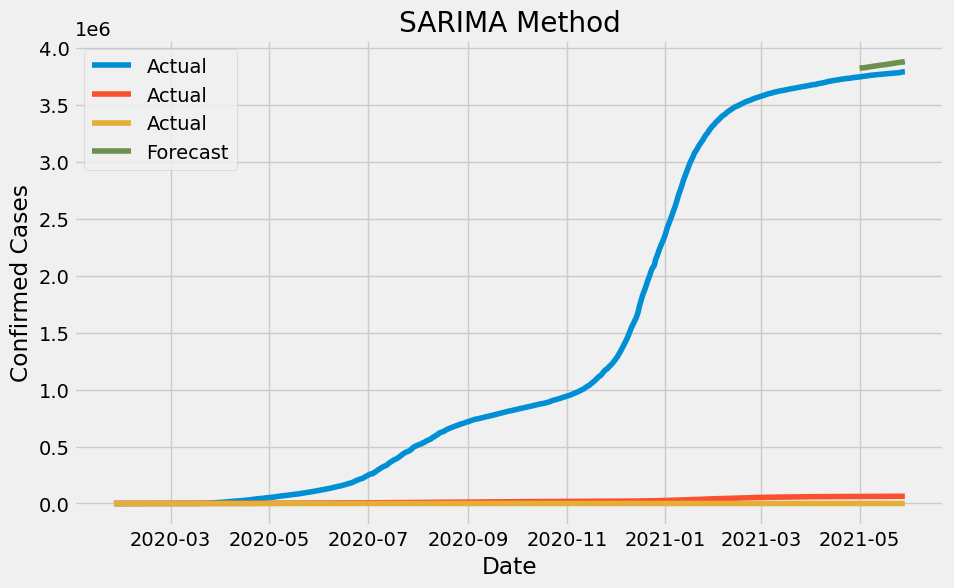

In [162]:
# 绘制原始数据和预测结果
plt.figure(figsize=(10, 6))
plt.plot(data, label='Actual')
plt.plot(yhat, label='Forecast')
plt.title('SARIMA Method')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.legend()
plt.show()

## Error Metrics
### Our RMSE error is 6601467840.640008
### Our MAE error is 81093.91063713128
### Our MAPE error is 2.15%

In [110]:
mean_squared_error(y_true=test['Confirmed'],
                   y_pred=yhat)

6601467840.640008

In [111]:
mean_absolute_error(y_true=test['Confirmed'],
                   y_pred=yhat)

81093.91063713128

In [112]:
mean_absolute_percentage_error(y_true=test['Confirmed'],
                   y_pred=yhat)

2.152524194340154

## 霍尔特-温特斯季节性模型

In [156]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

# 选择数据列
hwdata = train['Confirmed']

# 创建并拟合霍尔特-温特斯季节性模型
# 参数 seasonal_periods 根据数据的季节性周期进行调整
hwmodel = ExponentialSmoothing(hwdata, trend='add', seasonal='add', seasonal_periods=12).fit()

# 进行预测
pred = hwmodel.forecast(steps=67)

D:\Conda\anConda\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


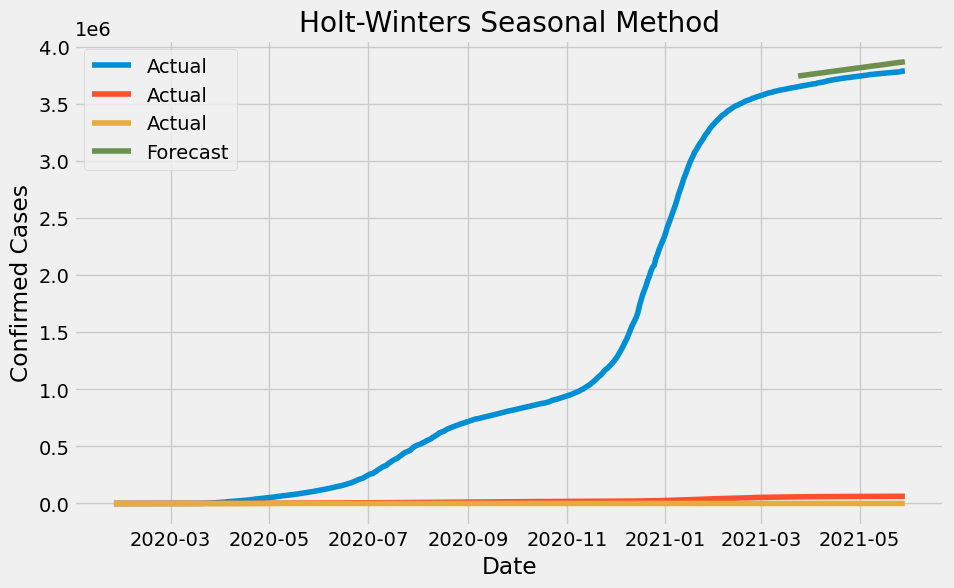

In [157]:
# 绘制原始数据和预测结果
plt.figure(figsize=(10, 6))
plt.plot(data, label='Actual')
plt.plot(pred, label='Forecast')
plt.title('Holt-Winters Seasonal Method')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.legend()
plt.show()

In [158]:
pred = pred[38:]

## Error Metrics
### Our RMSE error is 5828118112.657714
### Our MAE error is 76263.77711225502
### Our MAPE error is 2.024%

In [159]:
mean_squared_error(y_true=test['Confirmed'],
                   y_pred=pred)

5828118112.657714

In [160]:
mean_absolute_error(y_true=test['Confirmed'],
                   y_pred=pred)

76263.77711225502

In [161]:
mean_absolute_percentage_error(y_true=test['Confirmed'],
                   y_pred=pred)

2.024431103854988